# Pipeline
This small notebook serves to describe the usage and implementation of the python scripts used by the pipeline. Each section shows the flow of each script's main function, in a way to illustrate how they work.

In [1]:
RES_DIR="../proj/simulations/results/"
CONFIG_NAME="NonFrequentUpdates-#0"

These will be the results that will be used for this demonstration.

## Importing Data from Omnet
The process of importing results from their `sca` and `vec` formats (straight from a simulation run) is done in the parseData script

First, the script converts data to their csv format using `scavetool` and opens the csvs as dataframes.

In [2]:
from parseData import convertToCsv, filterMetrics, filterNans, openDatasets, saveCsv, convertValsToList
convertToCsv(RES_DIR, CONFIG_NAME)

sca, vec = openDatasets(CONFIG_NAME) # This opens the files and parses some values into a workable format
# Remove entries that don't have data
sca, vec = filterNans(sca, vec)
sca, vec = convertValsToList(sca, vec)

Exported 22905 scalars, 51800 parameters, 171 statistics, 1422 histograms
Exported 3905 vectors


/home/jm/Documents/Work/NetworkSimulation/NS2022/result_pipeline/parseData.py:19: DtypeWarning: Columns (6,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  sca = pd.read_csv(config_name + "_sca.csv")


### Metrics
Then, the scripts filters all data to select only the attributes that we deem relevant and want to analyze later.
Bellow are the metrics we chose to filter:
+ link layer throughput => eth mac txPk
+ application layer throughput - => Load in routers (incomingDataRate)
+ end to end delay? => Useful?
+ request-response/communication latency
+ link utilization => Use throughput and channel capacity
+ number of train updates that the server has received by simulation time=> Vector
+ Number of train updates sent as a response to each client request => Histogram + vector
+ Number of train updates that were discarded per request as a result of being expired => Vector + hist

We save this data to override the original csvs

In [3]:
import pandas as pd
# The values bellow are replicated to parseData, to change the scripts go there instead.
# Vectors - parse vec dataset
linkLayerThroughput = lambda x: (x["name"] == "txPk:vector(packetBytes)") & (("type" not in x) or (x["type"] == "vector"))
appLayerUtilization = lambda x: (x["name"].str.contains("Utilization")) & (("type" not in x) or (x["type"] == "vector"))
appLayerThroughput = lambda x: (x["name"].str.contains("DataRate")) & (("type" not in x) or (x["type"] == "vector")) #  (x["module"].str.contains("Router")) => Use this to filter only router
clientResponseDelay = lambda x: x["name"] == "timeToResponse"
serverSentTrainUpdates = lambda x: (x["name"] == "serverSentTrainUpdates")
serverDroppedTrainUpdates = lambda x: (x["name"] == "serverDroppedTrainUpdates")
serverReceivedTrainUpdates = lambda x: (x["name"] == "serverReceivedTrainUpdates")
vec_metrics = (linkLayerThroughput, appLayerThroughput, clientResponseDelay, serverSentTrainUpdates, serverDroppedTrainUpdates, serverReceivedTrainUpdates)

filterByClients = lambda x: x["module"].str.contains("client\[")
filterByClientRouter = lambda x: x["module"].str.contains("clientR")
filterByTrains = lambda x: x["module"].str.contains("train\[")
filterByTrainRouter = lambda x: x["module"].str.contains("trainR")
filterByServer = lambda x: x["module"].str.contains("server")
filterByIncomingTraffic = lambda x: x["name"].str.contains("incoming")
filterByOutgoingTraffic = lambda x: x["name"].str.contains("outgoing")

# Histograms - parse sca dataset
clientEndToEndDelay = lambda x: (x["name"] == "endToEndDelay:histogram")  & (x["module"].str.contains("client")) & (("type" not in x) or (x["type"] == "histogram"))
#sca_metrics = (clientEndToEndDelay, trainEndToEndDelay)
sca_metrics = [clientEndToEndDelay]

# vec[linkLayerThroughput]
#counts = sca["name"].value_counts()
#counts.to_csv('name.csv',index=True)

# Filter metrics only selects the values above
sca, vec = filterMetrics(sca, vec)
vec


,run,module,name,vectime,vecvalue
5120,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.train[0].eth[0].mac,txPk:vector(packetBytes),"[5.76e-06, 2.554e-05, 14.557725945102, 29.4393...","[64.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166...."
5125,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.train[1].eth[0].mac,txPk:vector(packetBytes),"[5.76e-06, 2.554e-05, 6.840765413857, 15.03997...","[64.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166...."
5130,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.train[2].eth[0].mac,txPk:vector(packetBytes),"[5.76e-06, 2.554e-05, 8.768540764201, 22.86400...","[64.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166...."
5135,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.train[3].eth[0].mac,txPk:vector(packetBytes),"[5.76e-06, 2.554e-05, 13.960477957361, 23.3744...","[64.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166...."
5140,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.train[4].eth[0].mac,txPk:vector(packetBytes),"[5.76e-06, 2.554e-05, 10.904108103834, 21.9404...","[64.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166...."
...,...,...,...,...,...
19441,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.trainRouter.eth[168].queue,incomingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19447,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.trainRouter.eth[169].queue,outgoingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19453,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.trainRouter.eth[169].queue,incomingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19459,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.trainRouter.eth[170].queue,outgoingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [4]:
def calcAppUtilization(throughput_df, channel_capacity, incoming):
    utilization_df = throughput_df.copy()
    utilization_df["vecvalue"] = utilization_df["vecvalue"].apply(lambda x: [i/channel_capacity for i in x])
    if incoming:
        direction = "incoming"
    else:
        direction = "outgoing"
    utilization_df["name"] = direction + "appUtilization" + ":vector"
    return utilization_df

# Calculate utilization and append it to vec dataframe
serverAppThroughputIncoming = vec[(appLayerThroughput(vec)) & (filterByServer(vec)) & (filterByIncomingTraffic(vec))]
utilization_df = calcAppUtilization(serverAppThroughputIncoming, 100e6, incoming=True)
vec = pd.concat([utilization_df, vec]).sort_index()


In [5]:
vec[vec["name"].str.contains("Utilization")]

,run,module,name,vectime,vecvalue
8076,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.server.eth[0].queue,incomingappUtilization:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
11724,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.server.eth[1].queue,incomingappUtilization:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[3.68e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [6]:
import numpy as np
def addVecValuesToSca(sca_df):
    # Merge Hists https://stackoverflow.com/questions/47085662/merge-histograms-with-different-ranges
    def extract_vals(hist):
        values = [[y]*int(x) for x, y in zip(hist[0], hist[1])]
        return np.array([z for s in values for z in s])

    sca_df["vecvalue"] = sca_df.apply(lambda x: extract_vals((x.binvalues, x.binedges)), axis=1)

addVecValuesToSca(sca)
sca

,run,module,name,count,sumweights,mean,stddev,min,max,binedges,binvalues,vecvalue
169880,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.client[0].app[0],endToEndDelay:histogram,203.0,203.0,0.000018,0.0,0.000018,0.000018,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[203.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
169917,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.client[1].app[0],endToEndDelay:histogram,208.0,208.0,0.000018,0.0,0.000018,0.000018,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[208.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
169954,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.client[2].app[0],endToEndDelay:histogram,202.0,202.0,0.000018,0.0,0.000018,0.000018,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[202.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Evaluate Results
The parseData script also uses the data produced in the previous step to generate statistics and results to be analyzed later using plots or tables.
The statistics that were deemed relevant are as follows:
+ link layer throughput and application layer throughput
  + clients => **calculate overall std, min, max**
  + server apps => **evolution of throughput**
+ end to end delay/request-response/communication latency => **clients histogram, max, mean, 99 percentile** - Quality of experience
+ link utilization => **Percentage Router to Server** => See if it's proportional to no of trains
+ number of train updates that the server has received by simulation time
+ Number of train updates sent as a response to each client request
+ Number of train updates that were discarded per request as a result of being expired => Relationship with delay, **Standard deviation, Max**j

The script simply adds new std, max, min, avg and mean columns to the existing dataset.

In [7]:
def addStatistics(df, colname):
    import numpy as np
    df[colname + "_std"] = df[colname].apply(lambda x: np.std(x))
    df[colname + "_max"] = df[colname].apply(lambda x: np.max(x))
    df[colname + "_min"] = df[colname].apply(lambda x: np.min(x))
    df[colname + "_mean"] = df[colname].apply(lambda x: np.mean(x))
    df[colname + "_avg"] = df[colname].apply(lambda x: np.average(x))

addStatistics(vec, "vecvalue")
#addStd(sca, "vecvalue")
vec


,run,module,name,vectime,vecvalue,vecvalue_std,vecvalue_max,vecvalue_min,vecvalue_mean,vecvalue_avg
5120,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.train[0].eth[0].mac,txPk:vector(packetBytes),"[5.76e-06, 2.554e-05, 14.557725945102, 29.4393...","[64.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166....",30.156305,166.0,64.0,156.129032,156.129032
5125,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.train[1].eth[0].mac,txPk:vector(packetBytes),"[5.76e-06, 2.554e-05, 6.840765413857, 15.03997...","[64.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166....",28.407306,166.0,64.0,157.355932,157.355932
5130,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.train[2].eth[0].mac,txPk:vector(packetBytes),"[5.76e-06, 2.554e-05, 8.768540764201, 22.86400...","[64.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166....",28.191311,166.0,64.0,157.500000,157.500000
5135,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.train[3].eth[0].mac,txPk:vector(packetBytes),"[5.76e-06, 2.554e-05, 13.960477957361, 23.3744...","[64.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166....",29.941439,166.0,64.0,156.285714,156.285714
5140,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.train[4].eth[0].mac,txPk:vector(packetBytes),"[5.76e-06, 2.554e-05, 10.904108103834, 21.9404...","[64.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166....",29.085882,166.0,64.0,156.892857,156.892857
...,...,...,...,...,...,...,...,...,...,...
19441,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.trainRouter.eth[168].queue,incomingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.0,0.0,0.000000,0.000000
19447,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.trainRouter.eth[169].queue,outgoingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.0,0.0,0.000000,0.000000
19453,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.trainRouter.eth[169].queue,incomingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.0,0.0,0.000000,0.000000
19459,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.trainRouter.eth[170].queue,outgoingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.0,0.0,0.000000,0.000000


In [8]:
saveCsv(sca, vec, CONFIG_NAME)

## Plotting Results
The generatePlots script uses the statistics generated by the previous script to generate plots to visualize results. The following plots are generated in this step as they were deemed most relevant:

+ link layer throughput and application layer throughput
  + clients => plot along time => Load coming from clients
  + server apps =>  plot along time => Load on server
+ end to end delay/request-response/communication latency => **clients histogram, max, mean, 99 percentile** - Quality of experience
+ link utilization => TODO **Percentage Router to Server** plot along time => See if it's proportional to no of trains
+ number of train updates that the server has received by simulation time => std, mean, avg
+ Number of train updates sent as a response to each client request => std, mean, avg
+ Number of train updates that were discarded per request as a result of being expired => Relationship with delay, **Standard deviation, Max** => std, mean, avg

Some functions to parse modules - for later use

In [9]:
vec[(appLayerThroughput(vec)) & (filterByClients(vec))]

,run,module,name,vectime,vecvalue,vecvalue_std,vecvalue_max,vecvalue_min,vecvalue_mean,vecvalue_avg
7861,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.client[0].eth[0].queue,incomingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1952.123049,22640.0,0.0,352.901598,352.901598
7879,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.client[0].eth[0].queue,outgoingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1952.123049,22640.0,0.0,352.901598,352.901598
8301,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.client[1].eth[0].queue,incomingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2010.278206,22640.0,0.0,367.125315,367.125315
8319,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.client[1].eth[0].queue,outgoingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2010.278206,22640.0,0.0,367.125315,367.125315
8580,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.client[2].eth[0].queue,incomingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1973.889150,22640.0,0.0,354.502944,354.502944
8598,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.client[2].eth[0].queue,outgoingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1973.889150,22640.0,0.0,354.502944,354.502944


Define function to plot metrics according to simulation time. Bins are created on the data so that the graph is more perceptible.

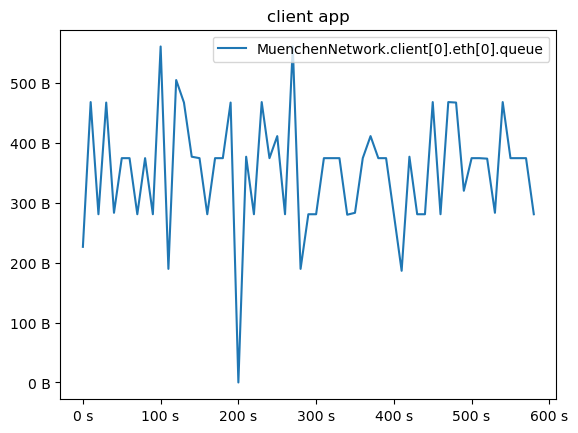

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import EngFormatter, PercentFormatter

def plotLine(data, N, label, units):
    def binData(x, y, N):
        if (N > len(y) or N == 0):
            n_x = x
            n_y = y
        else:
            n_y = np.average(y[:len(y) - len(y) % N].reshape(-1, N), axis=1)
            n_x = x[:len(x) - len(x) % N:N]
            if (len(y) % N) != 0:
                np.append(n_y, np.average(y[len(y) - len(y) % N:-1]))
                np.append(n_x, x[:-1])
        return n_x, n_y

    if isinstance(data, pd.Series):
        x, y = list(), list()
        x.append(np.array(data.vectime))
        y.append(np.array(data.vecvalue))
    else:
        x = [np.array(i.vectime) for _, i in data.iterrows()]
        y = [np.array(i.vecvalue) for _, i in data.iterrows()]

    fig, ax = plt.subplots()
    ax.set_title(label)

    for data_x, data_y, unit in zip(x, y, units):
        n_x, n_y = binData(data_x, data_y, N)
        formatterx = EngFormatter(unit="s")
        if (unit == "%"):
            formattery = PercentFormatter()
        else:
            formattery = EngFormatter(unit=unit)
        ax.xaxis.set_major_formatter(formatterx)
        ax.yaxis.set_major_formatter(formattery)
        sns.lineplot(x=n_x, y=n_y, ax=ax)
    ax.legend(labels=data[["module"]].to_numpy())
    


client = vec[(appLayerThroughput(vec)) & (filterByClients(vec))].iloc[0]
plotLine(client, 100, "client app", ["B"])

Throughput of incoming traffic to client nodes:

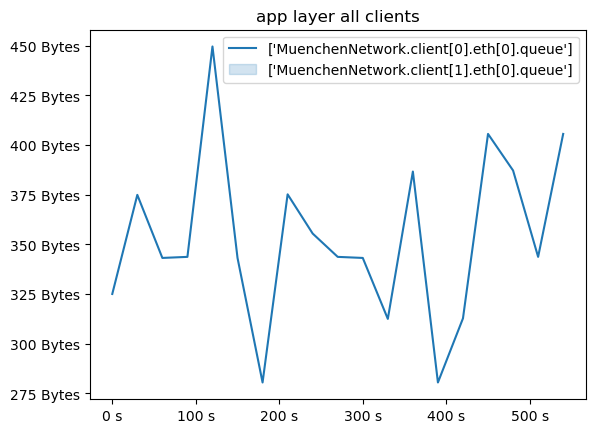

In [11]:
appLayerIncomingThroughput_Clients = vec[(appLayerThroughput(vec)) & (filterByClients(vec)) & (filterByIncomingTraffic(vec))]
plotLine(appLayerIncomingThroughput_Clients, 300, "app layer all clients", ["Bytes"])

Save results to csv

TODO:
+ ~~Use line plot draw functions to supposed time metrics~~
+ ~~Calculate link utilization~~
+ ~~Histogram with delays~~
+ Export graphs
+ Put functions in notebook into script
+ Put pipeline with makefile
  + Maybe separate scave_tool?

Line plots:
+ Load coming from clients => Link and App layer throughput
+ Load on server => Link and App Layer throughput
+ Link utilization Router to Server
+ number of train updates - received, sent as response and discarded

In [12]:
vec

,run,module,name,vectime,vecvalue,vecvalue_std,vecvalue_max,vecvalue_min,vecvalue_mean,vecvalue_avg
5120,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.train[0].eth[0].mac,txPk:vector(packetBytes),"[5.76e-06, 2.554e-05, 14.557725945102, 29.4393...","[64.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166....",30.156305,166.0,64.0,156.129032,156.129032
5125,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.train[1].eth[0].mac,txPk:vector(packetBytes),"[5.76e-06, 2.554e-05, 6.840765413857, 15.03997...","[64.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166....",28.407306,166.0,64.0,157.355932,157.355932
5130,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.train[2].eth[0].mac,txPk:vector(packetBytes),"[5.76e-06, 2.554e-05, 8.768540764201, 22.86400...","[64.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166....",28.191311,166.0,64.0,157.500000,157.500000
5135,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.train[3].eth[0].mac,txPk:vector(packetBytes),"[5.76e-06, 2.554e-05, 13.960477957361, 23.3744...","[64.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166....",29.941439,166.0,64.0,156.285714,156.285714
5140,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.train[4].eth[0].mac,txPk:vector(packetBytes),"[5.76e-06, 2.554e-05, 10.904108103834, 21.9404...","[64.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166....",29.085882,166.0,64.0,156.892857,156.892857
...,...,...,...,...,...,...,...,...,...,...
19441,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.trainRouter.eth[168].queue,incomingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.0,0.0,0.000000,0.000000
19447,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.trainRouter.eth[169].queue,outgoingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.0,0.0,0.000000,0.000000
19453,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.trainRouter.eth[169].queue,incomingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.0,0.0,0.000000,0.000000
19459,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.trainRouter.eth[170].queue,outgoingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.0,0.0,0.000000,0.000000


In [22]:
linePlots = [
    ("appLayerOutputThroughput_fromClients", 100, vec[(appLayerThroughput(vec)) & (filterByClients(vec)) & (filterByOutgoingTraffic(vec))], "Bytes"),
    ("appLayerOutputThroughput_toServers", 100, vec[(appLayerThroughput(vec)) & (filterByServer(vec)) & (filterByIncomingTraffic(vec))], "Bytes"),
    ("linkLayerOutputThroughput_fromClients", 0, vec[(linkLayerThroughput(vec)) & (filterByClients(vec))], "Bytes"),
    ("linkLayerOutputThroughput_toServers", 0, vec[(linkLayerThroughput(vec)) & (filterByServer(vec))], "Bytes"),
    ("appLayerUtilization_toServers", 100, vec[(appLayerUtilization(vec)) & (filterByServer(vec))], "%"),
    ("sentTrainUpdates_Server", 0, vec[serverSentTrainUpdates(vec)], "Nº Updates"),
    ("droppedTrainUpdates_Server", 0, vec[serverDroppedTrainUpdates(vec)], "Nº Updates"),
    ("receivedTrainUpdates_Server", 0, vec[serverReceivedTrainUpdates(vec)], "Nº Updates")
]

for title, NBins, data, format_type in linePlots:
    print(data.vecvalue)
    #plotLine(data, NBins, title, [format_type])
    break


7879    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
8319    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
8598    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: vecvalue, dtype: object


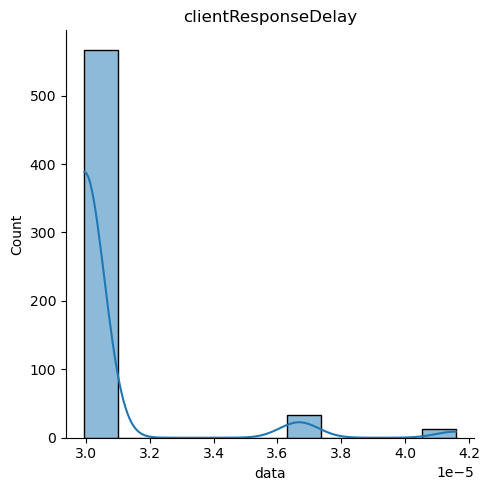

In [14]:
def drawHist(data, title, kde=True):
    # Get merged data into np array
    values = np.concatenate(data.vecvalue.to_numpy())
    
    df = pd.DataFrame(values).melt(var_name='column', value_name='data')
    sns.displot(data=df,
        x="data",
        col="column",
        kde=kde,
    ).set(title=title)

drawHist(vec[clientResponseDelay(vec)], "clientResponseDelay")

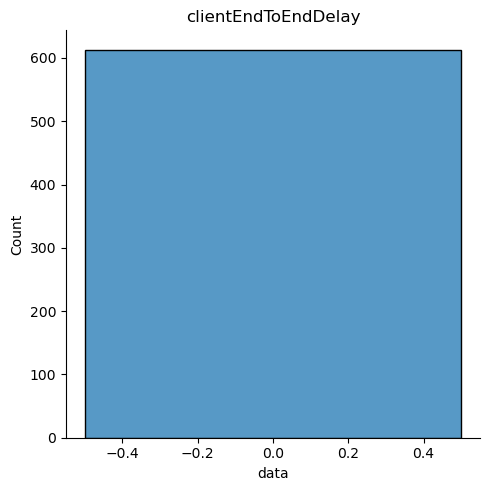

In [15]:
drawHist(sca[clientEndToEndDelay(sca)], "clientEndToEndDelay", kde=False)

In [16]:
sca[clientEndToEndDelay(sca)]

,run,module,name,count,sumweights,mean,stddev,min,max,binedges,binvalues,vecvalue
169880,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.client[0].app[0],endToEndDelay:histogram,203.0,203.0,0.000018,0.0,0.000018,0.000018,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[203.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
169917,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.client[1].app[0],endToEndDelay:histogram,208.0,208.0,0.000018,0.0,0.000018,0.000018,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[208.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
169954,NonFrequentUpdates-0-20221212-21:33:11-49507,MuenchenNetwork.client[2].app[0],endToEndDelay:histogram,202.0,202.0,0.000018,0.0,0.000018,0.000018,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[202.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
